<a href="https://colab.research.google.com/github/Darren-chan-jr/Databusters-Economic-Contraction-Prediction/blob/main/NUS_DSESC_DATABUSTERS_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Libraries Installation


In [ ]:
%pip install scikit-learn
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install scipy
%pip install pyarrow
%pip install shap
%pip install lightgbm
%pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,  classification_report, silhouette_score, confusion_matrix
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import scipy.cluster.hierarchy as sch
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense

# 2) Connecting to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3) Read Data

In [ ]:
MONTHLY_PATH = '/content/drive/MyDrive/data_dse/Monthly Data.csv' # To update acording to the path of your data file
monthly_df = pd.read_csv(MONTHLY_PATH)

In [ ]:
QUARTERLY_PATH = '/content/drive/MyDrive/data_dse/Quarterly Data.csv' # To update acording to the path of your data file
quarterly_df = pd.read_csv(QUARTERLY_PATH)

# 4) Data Cleaning

Handling Missing Values

In [ ]:
# Count missing values per column
missing_values = monthly_df.isnull().sum()
missing_values[missing_values > 0]

# Define thresholds
minimal_threshold = 5
moderate_threshold = 50
severe_threshold = 100

def categorize_missing(missing_values):
    minimal = missing_values[(missing_values > 0) & (missing_values <= minimal_threshold)]
    moderate = missing_values[(missing_values > minimal_threshold) & (missing_values <= moderate_threshold)]
    severe = missing_values[missing_values > severe_threshold]

    return minimal, moderate, severe

minimal_monthly, moderate_monthly, severe_monthly = categorize_missing(missing_values)

print(f"Minimal (1-5 values): {len(minimal_monthly)} columns")
print(f"Moderate (10-50 values): {len(moderate_monthly)} columns")
print(f"Severe (>100 values): {len(severe_monthly)} columns")



Minimal (1-5 values): 13 columns
Moderate (10-50 values): 6 columns
Severe (>100 values): 4 columns


In [ ]:
# Count missing values per column
missing_values = quarterly_df.isnull().sum()
missing_values[missing_values > 0]

minimal_quarterly, moderate_quarterly, severe_quarterly = categorize_missing(missing_values)

print(f"Minimal (1-5 values): {len(minimal_quarterly)} columns")
print(f"Moderate (10-50 values): {len(moderate_quarterly)} columns")
print(f"Severe (>100 values): {len(severe_quarterly)} columns")


Minimal (1-5 values): 23 columns
Moderate (10-50 values): 19 columns
Severe (>100 values): 16 columns


In [ ]:
#Filling Missing Values
def clean_missing_values(df, minimal_threshold=5, moderate_threshold=50, severe_threshold=100, drop_threshold=0.5):
    """
    Automatically categorizes columns with missing values and applies specific cleaning methods.

    - Minimal (1-5 missing values) → Forward-fill
    - Moderate (10-50 missing values) → Linear interpolation
    - Severe (>100 missing values) → Drop if >30% missing, else use regression-based imputation

    Args:
    - df (pd.DataFrame): The DataFrame to clean.
    - minimal_threshold (int): Upper bound for minimal missing values.
    - moderate_threshold (int): Upper bound for moderate missing values.
    - severe_threshold (int): Lower bound for severe missing values.
    - drop_threshold (float): Proportion of missing values threshold for dropping a column.

    Returns:
    - Cleaned DataFrame.
    """

    missing_counts = df.isnull().sum()
    total_rows = len(df)

    for col, missing in missing_counts.items():
        missing = missing_counts[col]
        if missing == 0:
            continue  # Skip columns with no missing data

        missing_ratio = missing / total_rows

        # Minimal Missing (1-5 values) → Forward-fill
        if missing <= minimal_threshold:
            df[col] = df[col].ffill()

        # Moderate Missing (10-50 values) → Linear interpolation
        elif missing <= moderate_threshold:
            df[col] = df[col].interpolate(method='linear')

        # Severe Missing (>100 values)
        elif missing > moderate_threshold:
            # Drop column if more than 30% missing
            if missing_ratio > drop_threshold:
                df.drop(columns=[col], inplace=True)
            else:
                # Regression-based imputation
                model = LinearRegression()
                df_notna = df.dropna(subset=[col])
                if not df_notna.empty:
                    X = df_notna.index.factorize()[0].reshape(-1, 1)  # Convert index to numerical
                    y = df_notna[col]
                    model.fit(X, y)
                    missing_idx = df[df[col].isna()].index.factorize()[0].reshape(-1, 1)
                    df.loc[df[col].isna(), col] = model.predict(missing_idx)

    return df

cleaned_monthly_df = clean_missing_values(monthly_df)
cleaned_quarterly_df = clean_missing_values(quarterly_df)


Final Checks

In [ ]:
# Verify no missing values remain
assert cleaned_monthly_df.isnull().sum().sum() == 0
assert cleaned_quarterly_df.isnull().sum().sum() == 0

Data Pre-Processing

In [ ]:

# Drop the first row (transformation codes) but keep headers
cleaned_monthly_df = cleaned_monthly_df.iloc[1:].reset_index(drop=True)

cleaned_monthly_df.rename(columns={"sasdate": "Date"}, inplace=True)
cleaned_monthly_df["Date"] = pd.to_datetime(cleaned_monthly_df["Date"])
cleaned_monthly_df.set_index("Date", inplace=True)



In [ ]:
# Drop the first 2 rows (transformation codes) but keep headers
cleaned_quarterly_df = cleaned_quarterly_df.iloc[2:].reset_index(drop=True)

cleaned_quarterly_df.rename(columns={"sasdate": "Date"}, inplace=True)
cleaned_quarterly_df["Date"] = pd.to_datetime(cleaned_quarterly_df["Date"])
cleaned_quarterly_df.set_index("Date", inplace=True)


#Feature Selection

In [ ]:
#Feature Selection
#From the cleaned quarterly data, we take only the selected columns based on our research and findings.


# List of columns to select
columns_to_select = [
    'GDPC1',           # Real GDP
    'UNRATE',          # Unemployment Rate
    'PERMIT',          # New Private Housing Permit
    'MORTGAGE30US',    # 30 Year Conventional Mortgage Rate
    'FEDFUNDS',        # Effective Fed Funds Rate
    'A823RL1Q225SBEA', # Government Expenditure and Investment
    'S&P 500',         # S&P 500
    'LIABPIx',         #Liabilities of Households and Nonprofit Organizations Relative to Personal Disposable Income (Percent)
    'CLAIMSx',        #Initial Claims
    'CPIAUCSL',       #Consumer Price Index for All Urban Consumers: All Items (Index 1982-84=100)
    'PPIACO',         #Producer Price Index for All Commodities (Index 1982=100)
    'PCDGx',           #Real personal consumption expenditures: Durable goods (Billions of Chained 2017 Dollars), deflated using its own price index
    'INDPRO',          #Industrial Production Index (Index 2017=100)
    'TCU',              #Capacity Utilization: Total Industry (Percent of Capacity)
    'ISRATIOx',         #Total Business: Inventories to Sales Ratio
    'UMCSENTx'        #University of Michigan: Consumer Sentiment (Index 1st Quarter 1966=100)
]

# Select the specified columns
selected_quarterly_df = cleaned_quarterly_df[columns_to_select]


# Exploratory Data Analysis

Number of quarters in contraction: 31
Total number of quarters: 263
Percentage of time in contraction: 11.79%


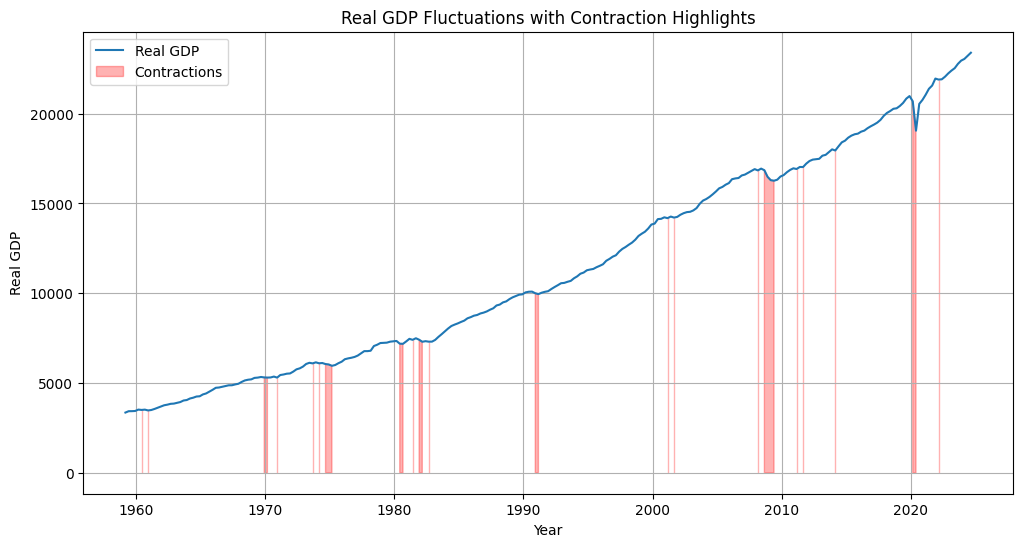

In [ ]:
# Calculate GDP growth rate (percentage change)
gdp_growth_rate = cleaned_quarterly_df['GDPC1'].pct_change() * 100

# Create a boolean mask for contractions (negative growth rate)
contractions = gdp_growth_rate < 0

# Create a new DataFrame to store contraction periods
contraction_periods = pd.DataFrame(index=selected_quarterly_df.index)
contraction_periods['Contraction'] = contractions

# Calculate the frequency of contractions (e.g., number of quarters in contraction)
contraction_frequency = contraction_periods['Contraction'].sum()
total_quarters = len(contraction_periods)
contraction_percentage = (contraction_frequency / total_quarters) * 100

# Print the frequency and percentage
print(f"Number of quarters in contraction: {contraction_frequency}")
print(f"Total number of quarters: {total_quarters}")
print(f"Percentage of time in contraction: {contraction_percentage:.2f}%")

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(selected_quarterly_df.index, selected_quarterly_df['GDPC1'], label='Real GDP')
plt.fill_between(selected_quarterly_df.index, selected_quarterly_df['GDPC1'], where=contractions, color='red', alpha=0.3, label='Contractions')
plt.title('Real GDP Fluctuations with Contraction Highlights')
plt.xlabel('Year')
plt.ylabel('Real GDP')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate lagged correlations for GDPC1 with other indicators (above 0.85)
lagged_correlations = {}
for col in cleaned_quarterly_df.columns:
    if col != 'GDPC1':
        lagged_corr = cleaned_quarterly_df['GDPC1'].corr(cleaned_quarterly_df[col].shift(1))  # 1-quarter lag
        if abs(lagged_corr) > 0.85:  # Filter for correlations above 0.85
            lagged_correlations[col] = lagged_corr

# Order indicators by importance (absolute correlation)
sorted_correlations = sorted(lagged_correlations.items(), key=lambda item: abs(item[1]), reverse=True)

# Count and describe the indicators
num_indicators = len(sorted_correlations)
print(f"\nThere are {num_indicators} indicators with a lagged correlation above 0.85 with GDP contraction.")
if num_indicators > 0:
    print("These indicators are:", ', '.join(lagged_correlations.keys()))


There are 130 indicators with a lagged correlation above 0.85 with GDP contraction.
These indicators are: PCECC96, PCDGx, PCESVx, PCNDx, GPDIC1, FPIx, Y033RC1Q027SBEAx, PNFIx, GCEC1, FGRECPTx, SLCEx, EXPGSC1, IMPGSC1, DPIC96, OUTNFB, OUTBS, INDPRO, IPFINAL, IPCONGD, IPMAT, IPDMAT, IPDCONGD, IPB51110SQ, IPNCONGD, IPBUSEQ, IPB51220SQ, PAYEMS, USPRIV, SRVPRD, NDMANEMP, USCONS, USEHS, USFIRE, USPBS, USLAH, USSERV, USTPU, USGOVT, USTRADE, USWTRADE, CES9092000001, CES9093000001, CE16OV, HOABS, HOANBS, CMRMTSPLx, AMDMUOx, INVCQRMTSPL, PCECTPI, PCEPILFE, GDPCTPI, GPDICTPI, IPDBS, DGDSRG3Q086SBEA, DSERRG3Q086SBEA, DNDGRG3Q086SBEA, DHCERG3Q086SBEA, DMOTRG3Q086SBEA, DFXARG3Q086SBEA, DGOERG3Q086SBEA, DONGRG3Q086SBEA, DHUTRG3Q086SBEA, DHLCRG3Q086SBEA, DTRSRG3Q086SBEA, DRCARG3Q086SBEA, DFSARG3Q086SBEA, DIFSRG3Q086SBEA, DOTSRG3Q086SBEA, CPIAUCSL, CPILFESL, WPSFD49207, PPIACO, WPSFD49502, WPSFD4111, PPIIDC, WPSID61, CES3000000008x, COMPRNFB, RCPHBS, OPHNFB, OPHPBS, ULCBS, ULCNFB, UNLPNBS, M2REAL, BUS

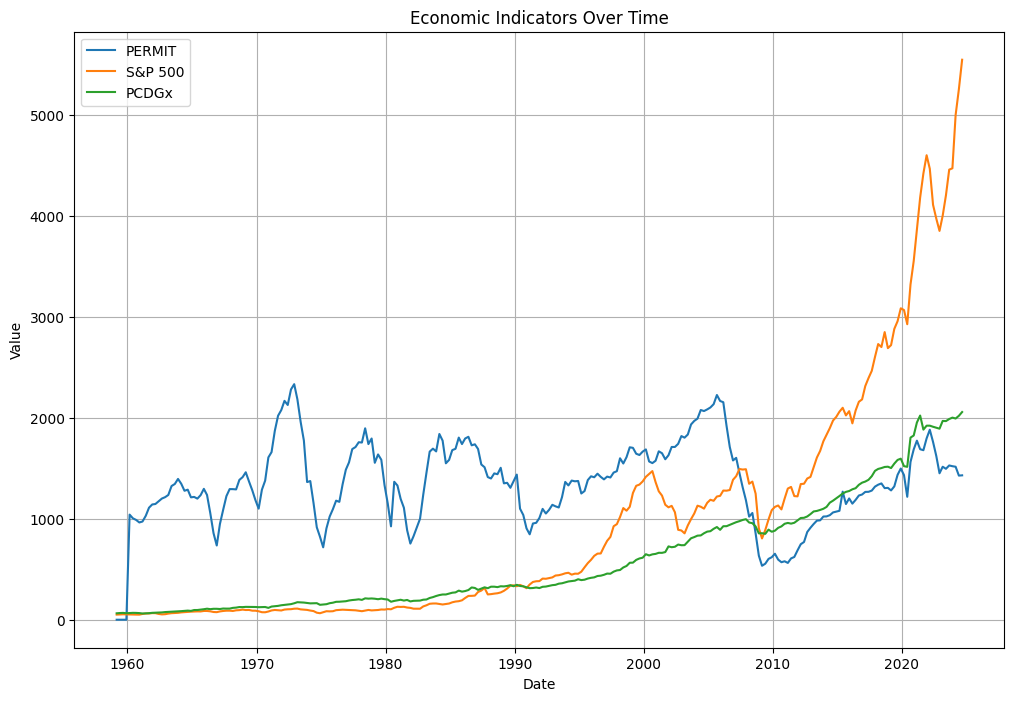

In [ ]:
# Select key indicators
key_indicators = [ "PERMIT", "S&P 500", "PCDGx"]

# Plot each indicator
plt.figure(figsize=(12, 8))
for col in key_indicators:
    plt.plot(cleaned_quarterly_df.index, cleaned_quarterly_df[col], label=col)

plt.legend()
plt.title("Economic Indicators Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.show()


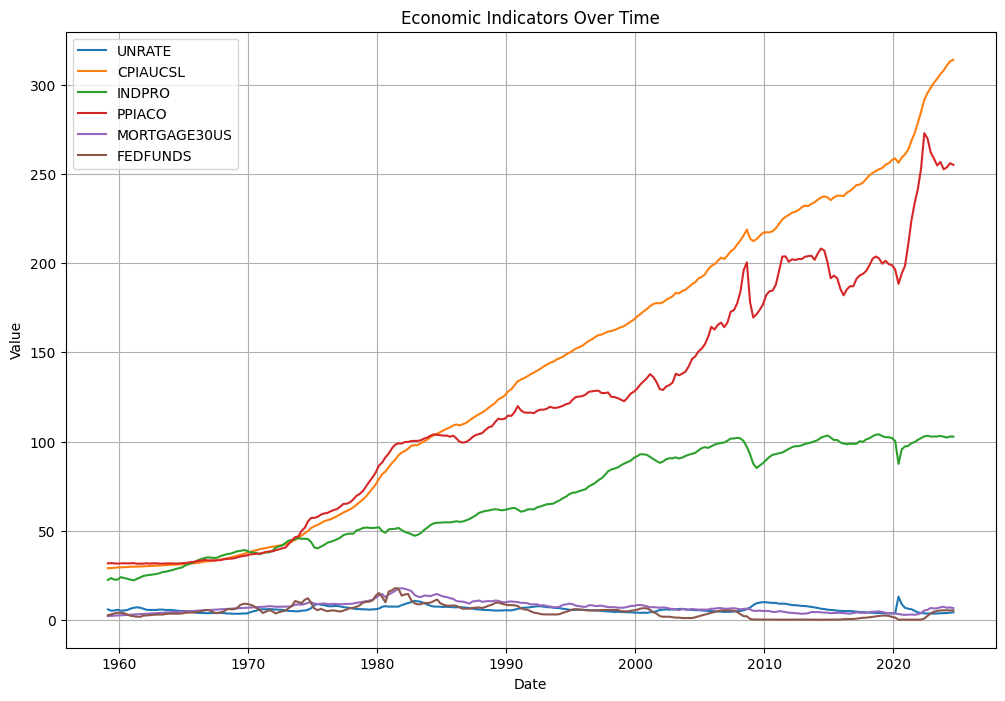

In [ ]:
# Select key indicators
key_indicators = [ "UNRATE", "CPIAUCSL", "INDPRO", "PPIACO",  "MORTGAGE30US",  "FEDFUNDS"]

# Plot each indicator
plt.figure(figsize=(12, 8))
for col in key_indicators:
    plt.plot(cleaned_quarterly_df.index, cleaned_quarterly_df[col], label=col)

plt.legend()
plt.title("Economic Indicators Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.show()

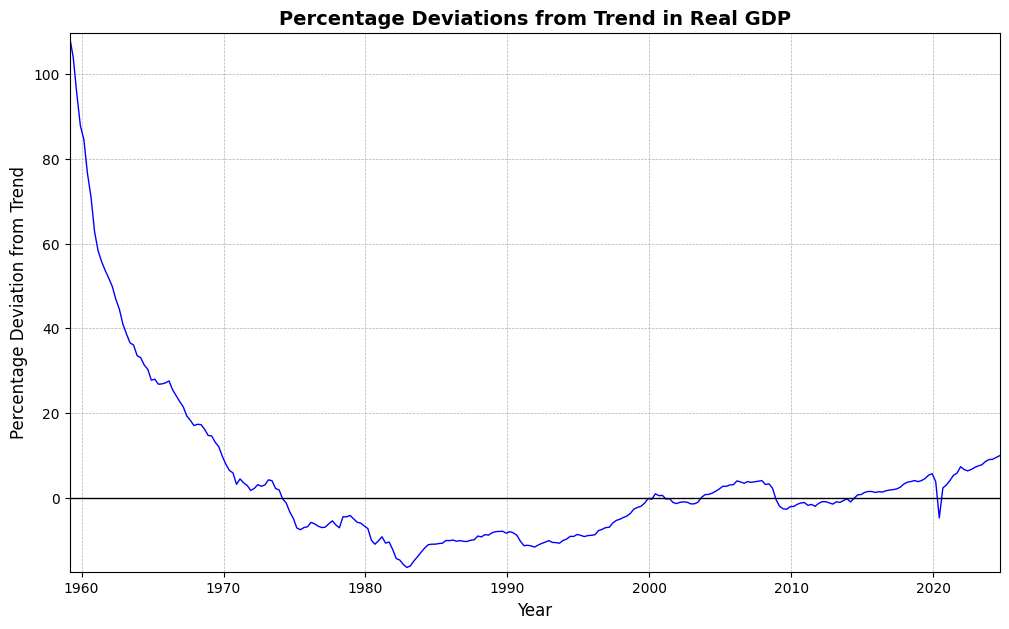

In [ ]:
gdp_data = cleaned_quarterly_df['GDPC1']

# Create numerical representation of the date index for regression
X = np.array(range(len(gdp_data))).reshape(-1, 1)
y = gdp_data.values

# Fit a linear regression model to estimate the trend
trend_model = LinearRegression()
trend_model.fit(X, y)

# Predict trend values
trend_values = trend_model.predict(X)

# Calculate percentage deviations from the trend
percentage_deviations = ((gdp_data - trend_values) / trend_values) * 100

# Create a DataFrame for plotting
deviations_df = pd.DataFrame({'Date': gdp_data.index, 'Deviation': percentage_deviations})
deviations_df.set_index('Date', inplace=True)

# Set dynamic y-axis limits with some padding
y_min = percentage_deviations.min() - 1
y_max = percentage_deviations.max() + 1

# Create the plot
plt.figure(figsize=(12, 7))
plt.plot(deviations_df.index, deviations_df['Deviation'], color='blue', linewidth=1)

# Add a solid horizontal line at y=0
plt.axhline(y=0, color='black', linewidth=1)

# Formatting
plt.title('Percentage Deviations from Trend in Real GDP', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage Deviation from Trend', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.ylim(y_min, y_max)  # Use dynamic y-limits
plt.xlim(deviations_df.index.min(), deviations_df.index.max())

# Show plot
plt.show()

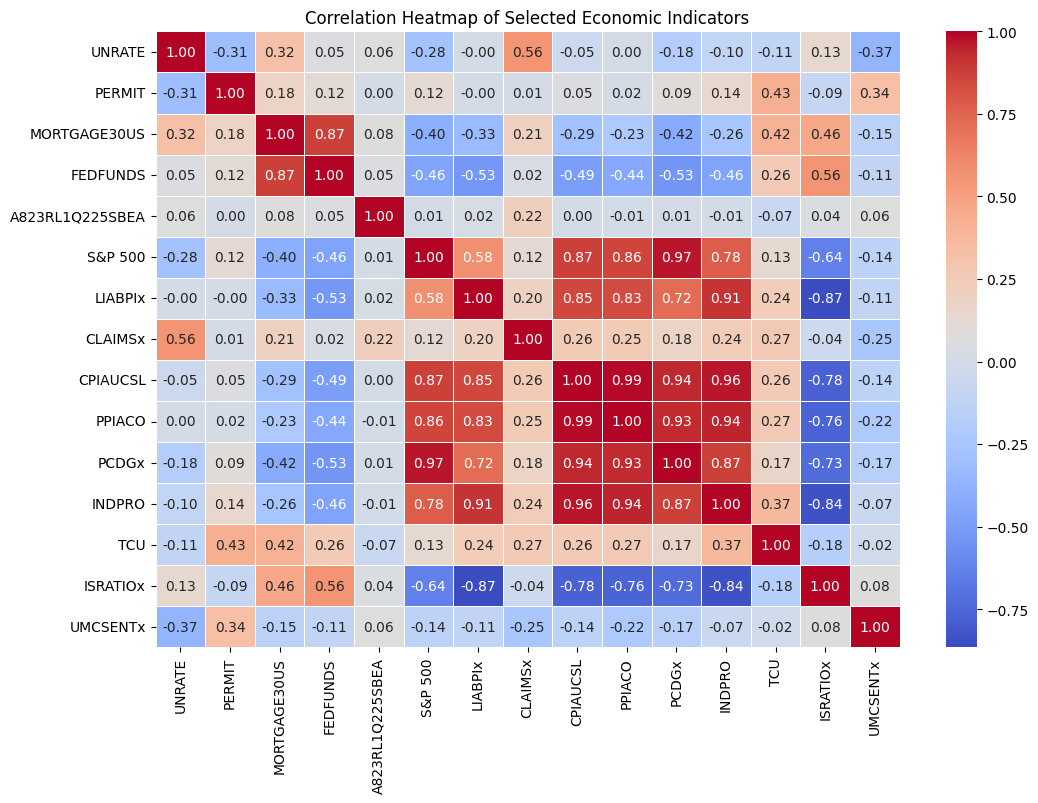

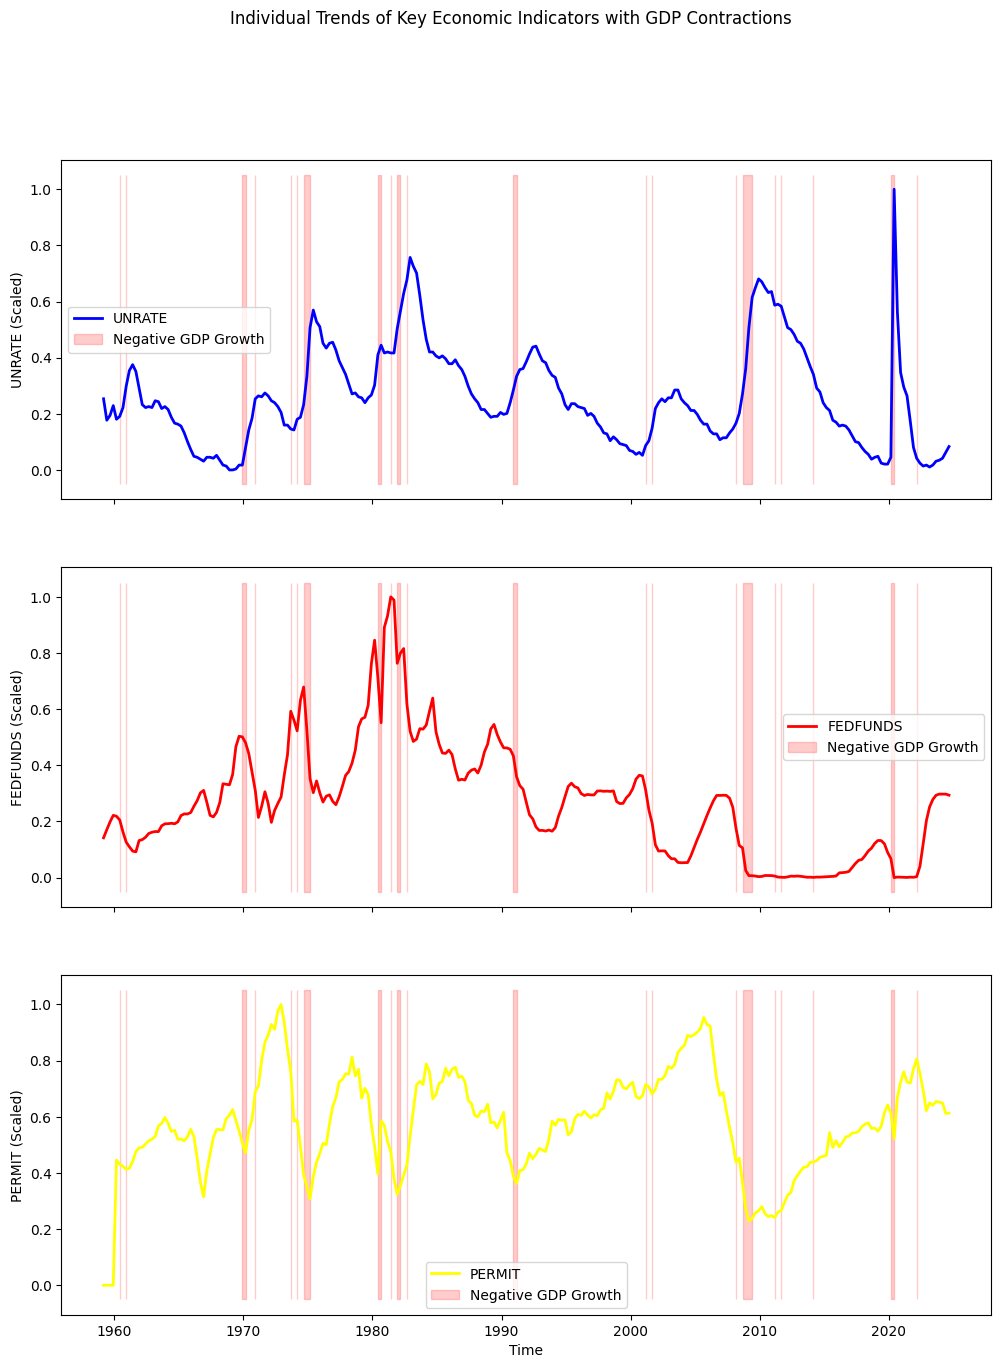

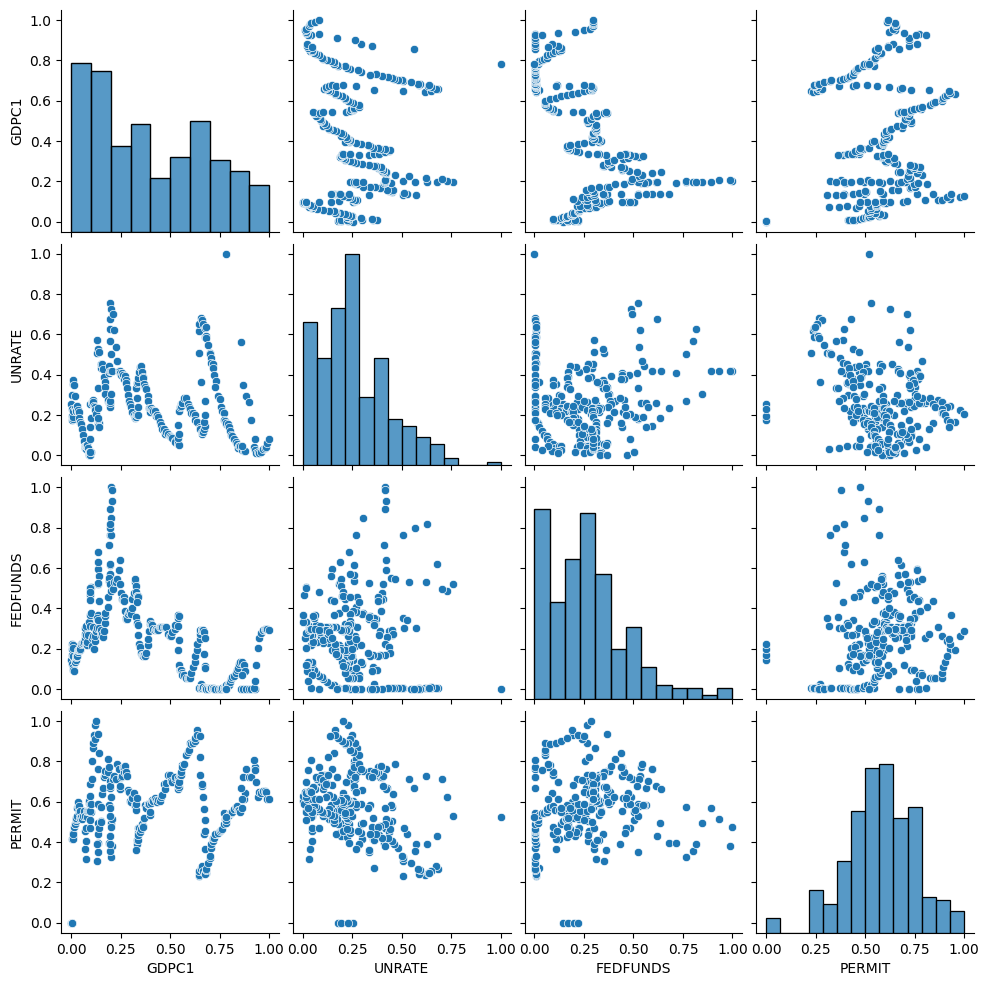

In [ ]:
# Normalize the variables to bring them to a comparable scale
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(selected_quarterly_df), index=selected_quarterly_df.index, columns=selected_quarterly_df.columns)

# 1. Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = scaled_data.drop(columns=["GDPC1"]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Selected Economic Indicators')
plt.show()

# 3. Separate Time Series Plots for Key Variables
variables_to_plot = ['UNRATE', 'FEDFUNDS', 'PERMIT']
colors = ['blue', 'red', 'yellow']
fig, axes = plt.subplots(len(variables_to_plot), 1, figsize=(12, 15), sharex=True)
negative_growth = selected_quarterly_df['GDPC1'].pct_change() < 0
for i, var in enumerate(variables_to_plot):
    ax = axes[i]
    ax.plot(scaled_data.index, scaled_data[var], label=var, color=colors[i], linewidth=2)
    ax.fill_between(scaled_data.index, ax.get_ylim()[0], ax.get_ylim()[1], where=negative_growth, color='red', alpha=0.2, label='Negative GDP Growth')
    ax.set_ylabel(f'{var} (Scaled)')
    ax.legend()
plt.xlabel('Time')
plt.suptitle('Individual Trends of Key Economic Indicators with GDP Contractions')
plt.show()

# 4. Pairplot for Relationships
sns.pairplot(scaled_data[['GDPC1'] + variables_to_plot])
plt.show()

#Feature Engineering

In [ ]:
#Creating our own inverted yield attribute (using it as a ratio, check for values above or below 1. magnitude varies)

# Calculate the Inverted Yield column
selected_quarterly_df['Inverted_Yield_ratio'] = cleaned_quarterly_df['TB3MS'] / cleaned_quarterly_df['GS10']

<ipython-input-19-254bfd75aa98>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_quarterly_df['Inverted_Yield_ratio'] = cleaned_quarterly_df['TB3MS'] / cleaned_quarterly_df['GS10']


In [ ]:
#if positive, it is inverted. if negative, not inverted
# Calculate the Inverted Yield column
selected_quarterly_df['is_Inverted_Yield'] = cleaned_quarterly_df['TB3MS'] - cleaned_quarterly_df['GS10']

<ipython-input-20-cc03db08b83e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_quarterly_df['is_Inverted_Yield'] = cleaned_quarterly_df['TB3MS'] - cleaned_quarterly_df['GS10']


In [ ]:
#From literature review, this ratio was deemed interestingly significant.

selected_quarterly_df['ratio_residential_gdp'] = cleaned_quarterly_df['PRFIx'] / selected_quarterly_df['GDPC1']


<ipython-input-21-013834f5033a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_quarterly_df['ratio_residential_gdp'] = cleaned_quarterly_df['PRFIx'] / selected_quarterly_df['GDPC1']


##INSERTING 3/6/12 MONTH LAGGED IsContraction flags

In [ ]:
df = selected_quarterly_df


df['GDP_Change_3M'] = df['GDPC1'].pct_change(1) * 100
df['GDP_Change_6M'] = df['GDPC1'].pct_change(2) * 100
df['GDP_Change_12M'] = df['GDPC1'].pct_change(4) * 100

# Create contraction flags (True if the GDP percentage change is negative)
df['isContraction_3M'] = df['GDP_Change_3M'] < 0
df['isContraction_6M'] = df['GDP_Change_6M'] < 0
df['isContraction_12M'] = df['GDP_Change_12M'] < 0

<ipython-input-22-1144c983a6bd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GDP_Change_3M'] = df['GDPC1'].pct_change(1) * 100
<ipython-input-22-1144c983a6bd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GDP_Change_6M'] = df['GDPC1'].pct_change(2) * 100
<ipython-input-22-1144c983a6bd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

# Extrapolating 2025 Data

In [ ]:
# Create a new DataFrame for 2025 predictions
future_quarters = pd.to_datetime(["2025-03-01", "2025-06-01", "2025-12-01"])
future_df = pd.DataFrame(index=future_quarters)

# Extrapolate each feature using linear regression
for col in columns_to_select:
    # Prepare training data (drop NaNs)
    historical_data = df[[col]].dropna()
    X_train = np.array(historical_data.index.factorize()[0]).reshape(-1, 1)  # Convert date index to numerical
    y_train = historical_data[col]

    # Train Linear Regression Model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict for future quarters
    future_X = np.array(range(len(df), len(df) + len(future_quarters))).reshape(-1, 1)
    future_df[col] = model.predict(future_X)

In [ ]:
# Make sure future_df has the same columns as df (except target variables)
missing_cols = [col for col in df.columns if col not in future_df.columns]

# Fill missing columns with NaN
for col in missing_cols:
    future_df[col] = np.nan  # Assign NaN to match df's structure

# Reorder columns to match df
future_df = future_df[df.columns]

# Append extrapolated 2025 data to historical data
extended_df = pd.concat([df, future_df])

# Random Forest Model

Splitting Training Data and Testing Data

In [ ]:
# Target variable for different prediction horizons
target_3M = 'isContraction_3M'
target_6M = 'isContraction_6M'
target_12M = 'isContraction_12M'

# Splitting training data (before 2024) and testing data (for 2025 predictions)
train_df = extended_df[extended_df.index < "2015-01-01"]
test_df = extended_df[extended_df.index >= "2015-01-01"]

# Define X (features) and y (target) for different prediction horizons
X_train, y_train_3M = train_df[columns_to_select], train_df[target_3M].astype(int)
X_train, y_train_6M = train_df[columns_to_select], train_df[target_6M].astype(int)
X_train, y_train_12M = train_df[columns_to_select], train_df[target_12M].astype(int)

X_test = test_df[columns_to_select]  # Features for predicting 2025


Training

In [ ]:
# Initialize Random Forest model
rf_model_3M = RandomForestClassifier(n_estimators=500, random_state=42)
rf_model_6M = RandomForestClassifier(n_estimators=500, random_state=42)
rf_model_12M = RandomForestClassifier(n_estimators=500, random_state=42)

# Train models
rf_model_3M.fit(X_train, y_train_3M)
rf_model_6M.fit(X_train, y_train_6M)
rf_model_12M.fit(X_train, y_train_12M)


RandomForestClassifier(n_estimators=500, random_state=42)

Prediction

In [ ]:
# Get probability predictions for the FULL test set (including rows with NaNs)
y_prob_3M_2025 = rf_model_3M.predict_proba(X_test)  # Use X_test, not X_test_no_na

# Set your custom threshold
custom_threshold_3M = 0.39

# Make predictions based on the custom threshold
y_pred_3M_2025_custom = (y_prob_3M_2025[:, 1] >= custom_threshold_3M).astype(int)

# Similarly, apply for 6M and 12M horizons (if needed)

y_prob_6M_2025 = rf_model_6M.predict_proba(X_test)
custom_threshold_6M = 0.4
y_pred_6M_2025_custom = (y_prob_6M_2025[:, 1] >= custom_threshold_6M).astype(int)

y_prob_12M_2025 = rf_model_12M.predict_proba(X_test)
custom_threshold_12M = 0.4
y_pred_12M_2025_custom = (y_prob_12M_2025[:, 1] >= custom_threshold_12M).astype(int)

# 3. Store results in a DataFrame (using custom predictions):
predictions_2025_custom = pd.DataFrame({
    "Quarter": test_df.index,
    "Predicted_Contraction_3M": y_pred_3M_2025_custom,
    "Predicted_Contraction_6M": y_pred_6M_2025_custom,
    "Predicted_Contraction_12M": y_pred_12M_2025_custom
})

# Display predictions with custom threshold
display(predictions_2025_custom)

,Quarter,Predicted_Contraction_3M,Predicted_Contraction_6M,Predicted_Contraction_12M
0,2015-03-01,0,0,0
1,2015-06-01,0,0,0
2,2015-09-01,0,0,0
3,2015-12-01,0,0,0
4,2016-03-01,0,0,0
5,2016-06-01,0,0,0
6,2016-09-01,0,0,0
7,2016-12-01,0,0,0
8,2017-03-01,0,0,0
9,2017-06-01,0,0,0


Evaluating Model Performance

In [ ]:
# Predictions on training set
y_pred_train_3M = rf_model_3M.predict(X_train)
y_pred_train_6M = rf_model_6M.predict(X_train)
y_pred_train_12M = rf_model_12M.predict(X_train)

# Evaluation function
def evaluate_model(y_true, y_pred, horizon):
    print(f"Evaluation for {horizon}-Month Horizon")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("\n" + "="*50 + "\n")

# Evaluate for each forecast horizon
evaluate_model(y_train_3M, y_pred_train_3M, "3")
evaluate_model(y_train_6M, y_pred_train_6M, "6")
evaluate_model(y_train_12M, y_pred_train_12M, "12")


Evaluation for 3-Month Horizon
Accuracy: 1.0
Confusion Matrix:
 [[196   0]
 [  0  28]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       196
           1       1.00      1.00      1.00        28

    accuracy                           1.00       224
   macro avg       1.00      1.00      1.00       224
weighted avg       1.00      1.00      1.00       224



Evaluation for 6-Month Horizon
Accuracy: 1.0
Confusion Matrix:
 [[202   0]
 [  0  22]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       202
           1       1.00      1.00      1.00        22

    accuracy                           1.00       224
   macro avg       1.00      1.00      1.00       224
weighted avg       1.00      1.00      1.00       224



Evaluation for 12-Month Horizon
Accuracy: 1.0
Confusion Matrix:
 [[203   0]
 [  0  21]]
Classification Report:
         

In [ ]:
horizons = {  # Dictionary to store data and models for each horizon
    3: {'target': target_3M, 'model': rf_model_3M},
    6: {'target': target_6M, 'model': rf_model_6M},
    12: {'target': target_12M, 'model': rf_model_12M}
}

custom_thresholds = { #Dictionary to store custom threshold for each prediction horizon
    3: 0.39,
    6: 0.4,
    12: 0.4
}

for horizon, data in horizons.items():
    target = data['target']
    model = data['model']
    custom_threshold = custom_thresholds[horizon]

    test_df_no_na = test_df.dropna(subset=[target])  # Drop NaNs for the specific target
    y_true = test_df_no_na[target].astype(int)
    X_test_no_na = test_df_no_na[columns_to_select]

    # Get probability predictions for filtered test set
    y_prob = model.predict_proba(X_test_no_na)[:, 1]

    # Apply custom threshold
    y_pred = (y_prob >= custom_threshold).astype(int)

    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)

    print(f"{horizon} Month Prediction")
    print(f"F1-score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Classification Report:\n{class_report}")
    print("-" * 50)  # Separator between horizons

3 Month Prediction
F1-score: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 0.6666666666666666
Confusion Matrix:
[[35  1]
 [ 1  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        36
           1       0.67      0.67      0.67         3

    accuracy                           0.95        39
   macro avg       0.82      0.82      0.82        39
weighted avg       0.95      0.95      0.95        39

--------------------------------------------------
6 Month Prediction
F1-score: 0.6666666666666666
Precision: 1.0
Recall: 0.5
Confusion Matrix:
[[35  0]
 [ 2  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        35
           1       1.00      0.50      0.67         4

    accuracy                           0.95        39
   macro avg       0.97      0.75      0.82        39
weighted avg       0.95      0.95      0.94       

<ipython-input-30-e7414fc935a8>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importances, palette="viridis")


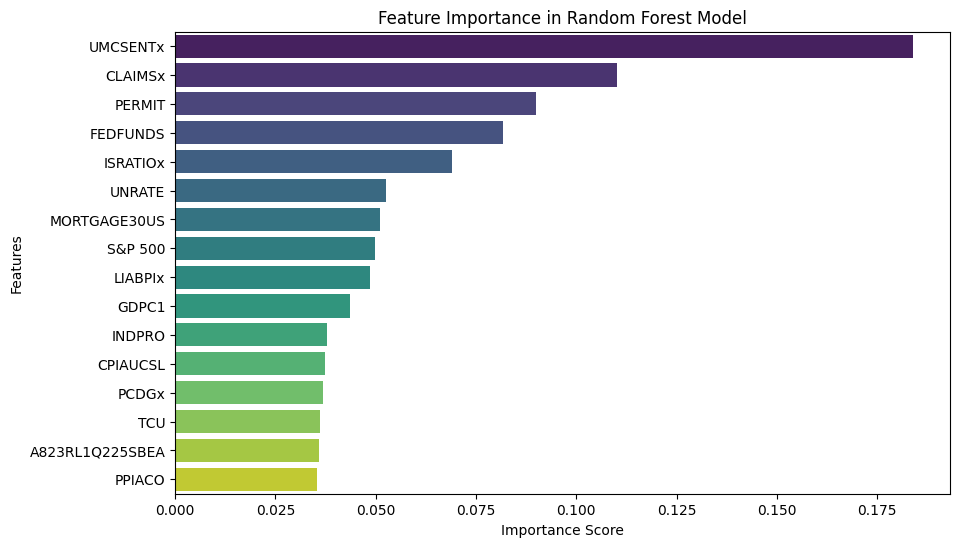

In [ ]:
# Get feature importance from trained model
feature_importances = pd.DataFrame({
    "Feature": columns_to_select,
    "Importance": rf_model_3M.feature_importances_
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances, palette="viridis")
plt.title("Feature Importance in Random Forest Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


# LSTM

In [ ]:
# 1. Convert target columns from object to numeric
target_cols = ['isContraction_3M', 'isContraction_6M', 'isContraction_12M']

for col in target_cols:
    extended_df[col] = pd.to_numeric(extended_df[col], errors='coerce')
    print(f"Value counts for {col}:\n", extended_df[col].value_counts())

# 2. Check missing values before imputation
print("Missing values before imputation:")
print(extended_df.isnull().sum())

# 3. Because your DataFrame index is a DatetimeIndex, try time interpolation
extended_df = extended_df.sort_index()  # ensure sorted by time
extended_df = extended_df.interpolate(method='time')

# 4. For any remaining gaps, fill forward and then backward
extended_df = extended_df.fillna(method='ffill').fillna(method='bfill')

# 5. If any NaNs remain in your target columns, drop those rows
extended_df = extended_df.dropna(subset=target_cols)

Value counts for isContraction_3M:
 isContraction_3M
0.0    232
1.0     31
Name: count, dtype: int64
Value counts for isContraction_6M:
 isContraction_6M
0.0    237
1.0     26
Name: count, dtype: int64
Value counts for isContraction_12M:
 isContraction_12M
0.0    239
1.0     24
Name: count, dtype: int64
Missing values before imputation:
GDPC1                    0
UNRATE                   0
PERMIT                   0
MORTGAGE30US             0
FEDFUNDS                 0
A823RL1Q225SBEA          0
S&P 500                  0
LIABPIx                  0
CLAIMSx                  0
CPIAUCSL                 0
PPIACO                   0
PCDGx                    0
INDPRO                   0
TCU                      0
ISRATIOx                 0
UMCSENTx                 0
Inverted_Yield_ratio     3
is_Inverted_Yield        3
ratio_residential_gdp    3
GDP_Change_3M            4
GDP_Change_6M            5
GDP_Change_12M           7
isContraction_3M         3
isContraction_6M         3
isContraction

<ipython-input-31-eb32a823d177>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  extended_df = extended_df.fillna(method='ffill').fillna(method='bfill')


In [ ]:
def windowed_df_to_date_X_Y(windowed_df):
  dates = windowed_df.index.to_numpy()
  df_as_np = windowed_df.to_numpy()
  # List all columns that are targets
  target_cols = ['isContraction_3M', 'isContraction_6M', 'isContraction_12M']
  #removed_cols = ['isContraction_3M', 'isContraction_6M', 'isContraction_12M','GDP_Change_3M','GDP_Change_6M', 'GDP_Change_12M', 'is_Inverted_Yield', 'BAA']

  # Use all other columns as features.
  # (If you want to drop any columns—say, if one of them is redundant—adjust accordingly.)
  feature_cols = extended_df.columns.difference(target_cols)

  # Extract features (X) and targets (Y)
  X = extended_df[feature_cols].values   # shape will be (n_samples, n_features)
  Y = extended_df[target_cols].values      # shape will be (n_samples, 3)

  # Because you plan to use an LSTM, reshape X to 3D.
  # If you are not yet using a sliding window (i.e. one timestep per sample), you can do:
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # Reshape X for LSTM: (n_samples, 1, n_features)
  X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
  X = X.reshape((X.shape[0], 1, X.shape[1]))


  #Univariate
  #dates = df_as_np[:, 0]

  #middle_matrix = windowed_df[['GDP_Change_3M', 'GDP_Change_6M', 'GDP_Change_12M']].to_numpy()

  #middle_matrix = df_as_np[:, 'GDP_Change_3M', 'GDP_Change_6M', 'GDP_Change_12M']
  #X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  #Y = windowed_df['GDPC1'].to_numpy()

  return dates, X_scaled.astype(np.float32), Y.astype(np.float32)

dates, X, Y = windowed_df_to_date_X_Y(extended_df)

dates.shape, X.shape, Y.shape
print(np.any(np.isnan(dates)))
print("Any NaNs in X?", np.any(np.isnan(X)))
print("Any NaNs in Y?", np.any(np.isnan(Y)))
#print(X)


False
Any NaNs in X? False
Any NaNs in Y? False


212
239


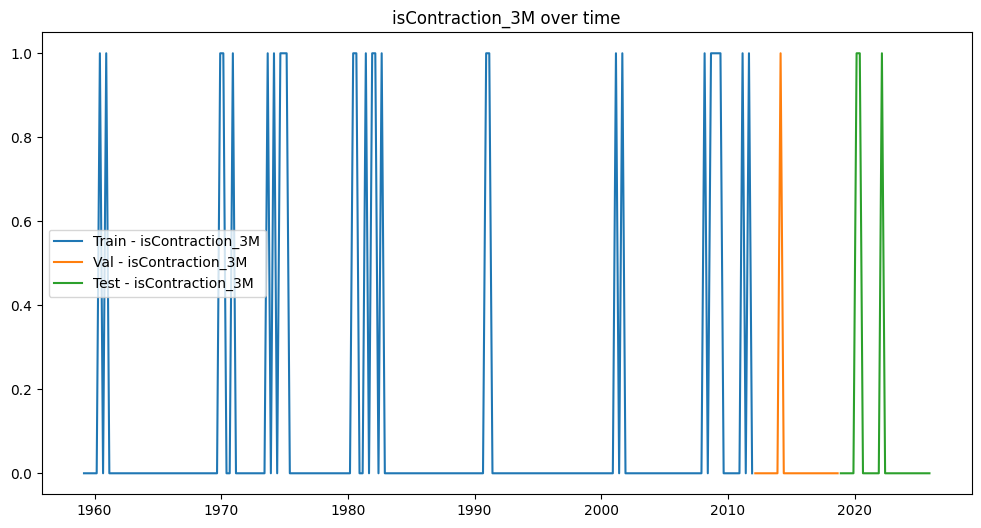

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          22,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,507 (99.64 KB)

 Trainable params: 25,507 (99.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.2899 - loss: 0.6689 - val_accuracy: 0.0000e+00 - val_loss: 0.6468
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0946 - loss: 0.5847 - val_accuracy: 0.0000e+00 - val_loss: 0.6134
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0300 - loss: 0.4648 - val_accuracy: 0.0000e+00 - val_loss: 0.5720
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0462 - loss: 0.3762 - val_accuracy: 0.3333 - val_loss: 0.5036
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1048 - loss: 0.2779 - val_accuracy: 0.8148 - val_loss: 0.3975
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1677 - loss: 0.2253 - val_accuracy: 0.9630 - val_loss: 0.2749
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2851 - loss: 0.1835 - val_accuracy: 1.0000 - val_loss: 0.1893
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5082 - loss: 0.1766 - val_

In [ ]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

print(q_80)
print(q_90)

dates_train, X_train_LSTM, Y_train_LSTM = dates[:q_80], X[:q_80], Y[:q_80]

dates_val, X_val_LSTM, Y_val_LSTM = dates[q_80:q_90], X[q_80:q_90], Y[q_80:q_90]
dates_test, X_test_LSTM, Y_test_LSTM = dates[q_90:], X[q_90:], Y[q_90:]

dates = extended_df.index.to_numpy()
plt.figure(figsize=(12, 6))
plt.plot(dates[:q_80], Y_train_LSTM[:, 0], label='Train - isContraction_3M')
plt.plot(dates[q_80:q_90], Y_val_LSTM[:, 0], label='Val - isContraction_3M')
plt.plot(dates[q_90:], Y_test_LSTM[:, 0], label='Test - isContraction_3M')
plt.legend()
plt.title("isContraction_3M over time")
plt.show()


# Determine input dimensions from X
n_timesteps = X.shape[1]  # in our case, 1 timestep per sample
n_features = X.shape[2]   # number of features (should be 19 in your case)

# Build the model. Adjust the architecture as needed.
model = Sequential([
    LSTM(64, input_shape=(n_timesteps, n_features)),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(3, activation='sigmoid')  # 3 outputs for isContraction_3M, 6M, and 12M
])

# Compile the model; use binary_crossentropy if your targets are binary.
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()
history = model.fit(
    X_train_LSTM, Y_train_LSTM,
    validation_data=(X_val_LSTM, Y_val_LSTM),
    epochs=100,
    batch_size=16  # adjust batch size as needed
)

#model.fit(X_train_LSTM, Y_train_LSTM, validation_data = (X_val_LSTM, Y_val_LSTM), epochs=100)


In [ ]:
test_predictions = model.predict(X_test_LSTM)
target_cols = ['isContraction_3M', 'isContraction_6M', 'isContraction_12M']
f1_scores = {}
best_thresholds = {}


for i, target in enumerate(target_cols):
    y_pred_probs = test_predictions[:, i]
    print(f"{target} prediction probabilities:")
    print(f"  min: {np.min(y_pred_probs):.4f}, max: {np.max(y_pred_probs):.4f}, mean: {np.mean(y_pred_probs):.4f}")

for i, target in enumerate(target_cols):
    best_thresh = 0.0
    best_f1 = 0.0
    # Define a grid from 0.08000 to 0.17000 in, say, 0.00001 increments.
    # (You might reduce the number of steps if this is too fine–grained.)
    thresholds = np.linspace(0.01, 1, num=1000)
    for thresh in thresholds:
        # Generate binary predictions using the candidate threshold.
        y_pred = (test_predictions[:, i] > thresh).astype(int)
        # Compute F1 score; use zero_division=0 to avoid warnings if no positives are predicted.
        current_f1 = f1_score(Y_test_LSTM[:, i].astype(int), y_pred, zero_division=0)
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_thresh = thresh
    best_thresholds[target] = best_thresh
    f1_scores[target] = best_f1

print("Optimal Thresholds (to five decimal places):", best_thresholds)
print("F1 Scores for all targets:", f1_scores)

#print("F1 Scores for all targets:", f1_scores)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
isContraction_3M prediction probabilities:
  min: 0.0000, max: 1.0000, mean: 0.2985
isContraction_6M prediction probabilities:
  min: 0.0000, max: 1.0000, mean: 0.0371
isContraction_12M prediction probabilities:
  min: 0.0000, max: 0.9999, mean: 0.0371
Optimal Thresholds (to five decimal places): {'isContraction_3M': 0.9563963963963965, 'isContraction_6M': 0.01, 'isContraction_12M': 0.01}
F1 Scores for all targets: {'isContraction_3M': 0.8, 'isContraction_6M': 0.4, 'isContraction_12M': 0.5}


In [ ]:
# Example for isContraction_3M:
optimal_thresh_3M = best_thresholds['isContraction_3M']
y_pred_3M = (test_predictions[:, 0] > optimal_thresh_3M).astype(int)
f1_3M = f1_score(Y_test_LSTM[:, 0].astype(int), y_pred_3M)
print(f"Using threshold {optimal_thresh_3M:.5f}, F1 for isContraction_3M: {f1_3M}")

Using threshold 0.95640, F1 for isContraction_3M: 0.8


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


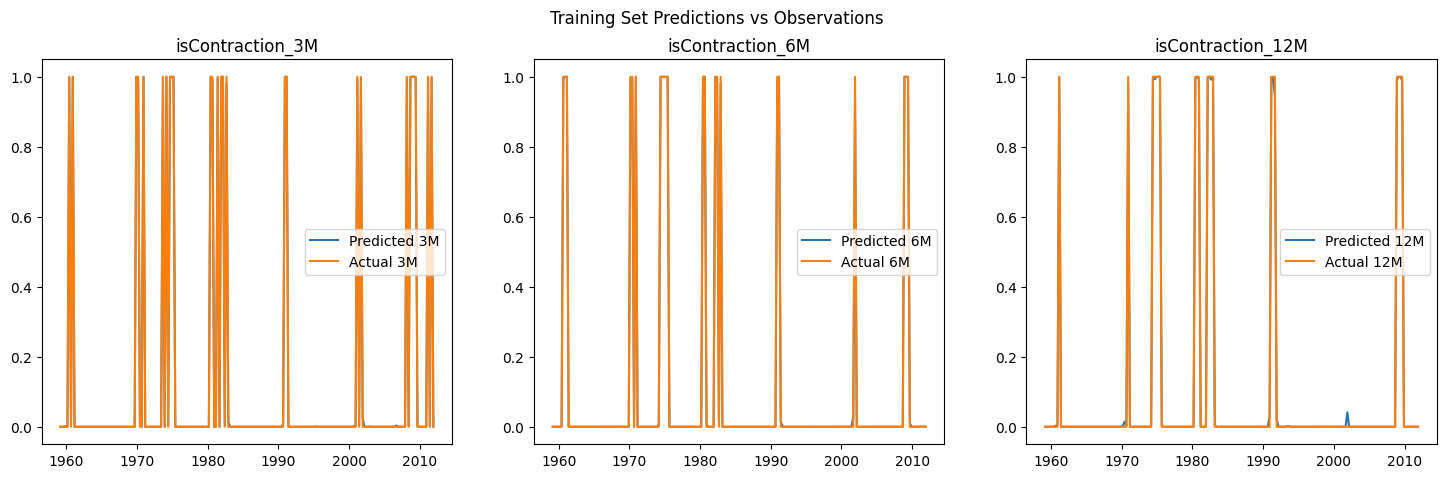

In [ ]:
# Get predictions for the training set.
# model.predict will now return an array of shape (n_samples, 3)
train_predictions = model.predict(X_train_LSTM)

# Create a figure with 3 subplots (one for each target)
plt.figure(figsize=(18, 5))

# For isContraction_3M (first target)
plt.subplot(1, 3, 1)
plt.plot(dates_train, train_predictions[:, 0], label='Predicted 3M')
plt.plot(dates_train, Y_train_LSTM[:, 0], label='Actual 3M')
plt.title('isContraction_3M')
plt.legend()

# For isContraction_6M (second target)
plt.subplot(1, 3, 2)
plt.plot(dates_train, train_predictions[:, 1], label='Predicted 6M')
plt.plot(dates_train, Y_train_LSTM[:, 1], label='Actual 6M')
plt.title('isContraction_6M')
plt.legend()

# For isContraction_12M (third target)
plt.subplot(1, 3, 3)
plt.plot(dates_train, train_predictions[:, 2], label='Predicted 12M')
plt.plot(dates_train, Y_train_LSTM[:, 2], label='Actual 12M')
plt.title('isContraction_12M')
plt.legend()

plt.suptitle("Training Set Predictions vs Observations")
plt.show()

In [ ]:
dates_2024, X_2024, Y_2024 = dates[-25:], X[-25:], Y[-25:]

predictions_2024 = model.predict(X_2024)


# print("Binary predictions using tuned thresholds:")
# for date, pred in zip(dates_2024, predictions_2024):
#     binary_pred = {}
#     for i, target in enumerate(target_cols):
#         # Use the corresponding best threshold for the current target
#         threshold = best_thresholds[target]
#         binary_pred[target] = int(pred[i] > threshold)
#     print(f"{date}: {binary_pred}")

rows = []
for date, pred in zip(dates_2024, predictions_2024):
    row = {"Date": date}
    for i, target in enumerate(target_cols):
        # Use the corresponding best threshold for the current target
        threshold = best_thresholds[target]
        row[target] = int(pred[i] > threshold)
    rows.append(row)

# Create a DataFrame from the list of dictionaries.
predictions_df = pd.DataFrame(rows)

# Optionally, set the 'Date' column as the DataFrame index.
predictions_df.set_index("Date", inplace=True)

# Print the table with a label.
print("Predictions:")
print(predictions_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Predictions:
            isContraction_3M  isContraction_6M  isContraction_12M
Date                                                             
2019-06-01                 0                 0                  0
2019-09-01                 0                 0                  0
2019-12-01                 0                 0                  0
2020-03-01                 1                 0                  0
2020-06-01                 1                 1                  1
2020-09-01                 0                 0                  0
2020-12-01                 0                 0                  0
2021-03-01                 0                 0                  0
2021-06-01                 0                 0                  0
2021-09-01                 0                 0                  0
2021-12-01                 0                 0                  0
2022-03-01                 0                 0                  0
2022-06-01               